In [1]:
# from utils import * 

import os
os.chdir("../../scVI/")
os.getcwd()

import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from statsmodels.stats.multitest import multipletests

save_path = '../CSF/Notebooks/'

In [2]:
celllabels = np.load(save_path + 'meta/CD4.clusters.npy')
celltypes, labels = np.unique(celllabels,return_inverse=True)

In [3]:
celltypes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [4]:
with open(save_path + 'DE/control_tissue.DEres_CD4.pkl', 'rb') as f:
    tissueDE,tissueDEclust = pickle.load(f)
    
genenames = pd.read_csv('../CSF/RFiles/genenames.csv',header=None)


In [5]:
print(celltypes[tissueDEclust])
print("total %i cell types"%len(tissueDE))

[ 0  1  2  3  4  5  6  7  8  9 10]
total 11 cell types


In [6]:
celltype = []
combinedDEres = []
for i,x in enumerate(celltypes[tissueDEclust]):
    temp  = pd.read_csv('../CSF/DE/wilcoxon/MannWhitneyU.CD4.tissue_control.%s.csv'%x)
    fdr_wil = multipletests(temp['pvalue'],method='fdr_bh')
    temp.index = list(genenames[0])
    temp = pd.concat([temp,tissueDE[i]],axis=1,sort=True)
    temp = temp.sort_values(by='bayes1',ascending=False)
    combined = deepcopy(temp[['stat','pvalue','bayes1','bayes2','mean1','mean2','nonz1','nonz2','clusters']])
    combined['scVI_logFC'] = np.log(temp['scale1']/temp['scale2'])
    combined['norm_logFC'] = np.log(temp['norm_mean1']/temp['norm_mean2'])
    temp  = pd.read_csv('../CSF/EdgeR/CD4.tissue_control.batch_corrected.%s.edgeR.csv'%x)
    temp.index = list(genenames[0])
    temp = temp[['logFC','logCPM','F','PValue']]
    fdr_edgeR = multipletests(temp['PValue'],method='fdr_bh')
    combined = pd.concat([combined,temp],axis=1,sort=True)
    combined['fdr_wil'] = fdr_wil[1]
    combined['fdr_edgeR'] = fdr_edgeR[1]
    celltype.append(x)
    combinedDEres.append(combined)


/data/yosef2/users/chenling/miniconda3/envs/pytorch_new/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [7]:
from pandas import ExcelWriter
import xlsxwriter


writer = pd.ExcelWriter(save_path + 'DE/tissue_control.CD4.xlsx', engine='xlsxwriter')
for i, x in enumerate(celltype):
    combinedDEres[i].to_excel(writer, sheet_name=str(x))
writer.close()


# VisualizatioN

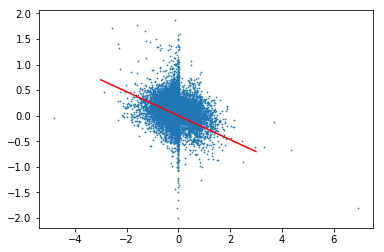

In [8]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt


%matplotlib inline

x = combinedDEres[3]['logFC']
y = combinedDEres[3]['scVI_logFC']
xrange = np.max(np.abs(x))
plt.scatter(x,y,s=.5)
cor = np.asarray(pd.concat([x,y],1).corr())[0,1]
plt.plot([-3,3],[-3*cor,3*cor],'r-')

# GSEA

In [9]:
import gseapy as gp
gmt = ['c7.all.v6.2.symbols.gmt',
       'Hemato.geneset.gmt',
       'cell_cycle_Tirosh.gmt',
       'chenling.gmt',
       'netPath.gmt',
       'codeset.gmt',
       'signatures_NY_private.gmt']
gmt = ['../CSF/signatures/'+x for x in gmt]

def DE_GSEA(filtered,gmt,celltypes,filename):
    gsea_res = []
    for x in filtered:
        if len(x)>0:
            res1 = gp.enrichr(gene_list=list(x.index),
                     gene_sets=['KEGG_2016'],
                     cutoff=0.5                    )
            res2 = gp.enrichr(gene_list=list(x.index),
                             gene_sets=gmt,
                             cutoff=0.5,
                             background=10266)
            res = pd.concat([res1.results,res2.results])
            res = res.sort_values(by='P-value')
            res['cluster'] = celltypes[list(x['clusters'])[0]]
            gsea_res.append(res.loc[res['Adjusted P-value']<0.05])
    gsea_res = pd.concat(gsea_res)
    gsea_res = gsea_res[['Adjusted P-value','Genes','Term','Overlap','cluster']]
    gsea_res.to_csv(filename)
    return(gsea_res)


# upregulated in CSF

In [10]:
filtered = [x.loc[(x['fdr_wil']<0.2)&(x['fdr_edgeR']<0.2)& 
                  (x['bayes1']>0.3) &
                  (x['logFC']<0) & (x['norm_logFC']>0)] for x in combinedDEres]

DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)

DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes = DEgenes.sort_index()
DEgenes.to_csv(save_path+'DE/CD4.control_tissue.upregulated.relaxed.csv')

In [11]:
%%capture
gsea_res = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/CD4.control_tissue.upregulated.relaxed.GSEA.csv')

In [12]:
filtered = [x.loc[(x['fdr_wil']<0.05)&(x['fdr_edgeR']<0.05)& 
                  (x['bayes1']>0.5) &
                  (x['logFC']<0) & (x['norm_logFC']>0)] for x in combinedDEres]

DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)

DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes = DEgenes.sort_index()
DEgenes.to_csv(save_path+'DE/CD4.control_tissue.upregulated.csv')


In [13]:
%%capture
gsea_res = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/CD4.control_tissue.upregulated.GSEA.csv')

# downregulated in PBMC

In [14]:

filtered = [x.loc[(x['fdr_wil']<0.2)&(x['fdr_edgeR']<0.2)& 
                  (x['bayes2']>0.3) &
                  (x['logFC']>0) & (x['norm_logFC']<0)] for x in combinedDEres]


DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)
DEgenes = DEgenes.sort_index()
DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]

DEgenes.to_csv(save_path+'DE/CD4.control_tissue.downregulated.relaxed.csv')

In [15]:
%%capture
gsea_res = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/CD4.control_tissue.downregulated.relaxed.GSEA.csv')

In [16]:
filtered = [x.loc[(x['fdr_wil']<0.05)&(x['fdr_edgeR']<0.05)& 
                  (x['bayes2']>0.5) &
                  (x['logFC']>0) & (x['norm_logFC']<0)] for x in combinedDEres]
DEgenes = pd.concat(filtered)
geneid, nocc = np.unique(DEgenes.index,return_counts=True)
shared = pd.DataFrame([geneid,nocc],index=['genename','occ']).T
shared = shared.sort_values(by='occ',ascending=False)
DEgenes = DEgenes.sort_index()
DEgenes['clusters'] = np.asarray(celltypes)[np.asarray(DEgenes['clusters']).astype(int)]
DEgenes.to_csv(save_path+'DE/CD4.control_tissue.downregulated.csv')

In [17]:
%%capture
gsea_res = DE_GSEA(filtered,gmt,celltypes,save_path+'DE/CD4.control_tissue.downregulated.GSEA.csv')